In [1]:
# import relevant libraries here 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.cluster import KMeans

### Understanding the components of Time Series Data set

In this exercise, you will simulate a time series dataset. This will help us better understand the components of a time series and the concepts underlying time series analysis and grok, so to speak, the steps that go into modeling time series by fitting a model to it.

The goal is the build a data set that is most similar to the one below.

<img src="images/simulated_dataset.png" alt="drawing" style="width:800px;"/>

## Use your understanding of how seasonality trend and noise interact in a time series to generate data set similar to the one above.
The information that you need to reproduce this dataset is provided below:

* The data contains 200 months worth of data

* The trend is an exponential function: 

$$y = 29 + 1.01^x $$,

* The seasonaity in this dataset is quaterly (frequency of 4 months)
and is a sine curve with amplitude of 1.2

* The noise is Gaussian with mean of $\mu=0$ and $\sigma=0.5$  

1. Compute and plot each of the components of your time series independently.

* Plot your dta to verify your solutiojn. Your plots should look like the following:

<img src="images/three_plots.png" alt="drawing" style="width:500px;"/>

2. Generate the time series by combining the three components. 

Important: use the following seed so that graph matches the one above exactly. 

```
np.random.seed(42)
```

In [2]:
# write  your code for simulating the trend
np.random.seed(42)
x_trend = np.arange(200)
y_trend = 29 + 1.01 ** x_trend

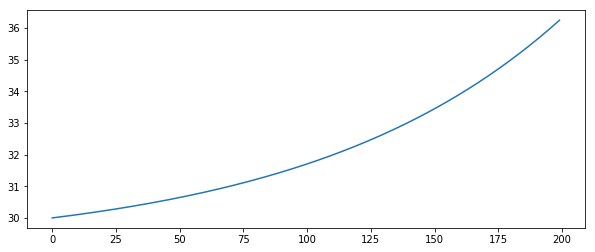

In [3]:
# plot your trend 
plt.figure(figsize=(10, 4))
plt.plot(x_trend, y_trend)

In [4]:
# write  your code for simulating the seasonality
x_seasonality = np.arange(0, 200, 0.1)
y_seasonality = np.sin(np.pi / 2 * x_seasonality) * 1.2

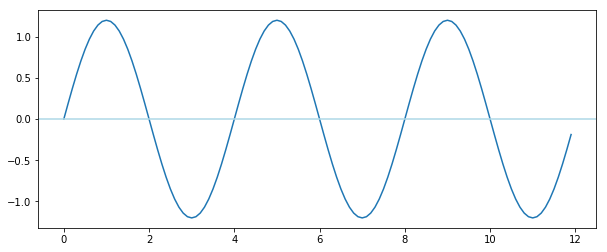

In [5]:
# plot your seasonality 
plt.figure(figsize=(10, 4))
plt.plot(x_seasonality[:120], y_seasonality[:120])
plt.axhline(0, c='lightblue')

In [6]:
# write  your code for simulating the noise 
x_noise = np.arange(200)
y_noise = np.random.normal(0, 0.5, 200)

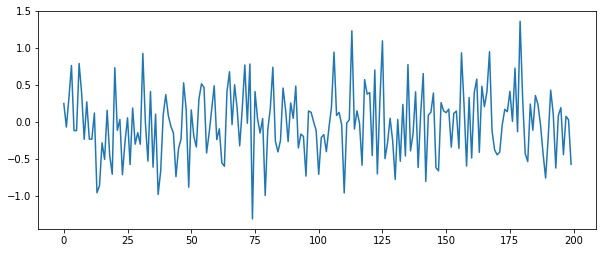

In [7]:
# plot your random noise
plt.figure(figsize=(10, 4))
plt.plot(x_noise, y_noise)

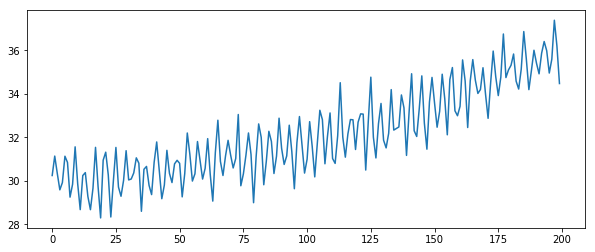

In [8]:
# compute and plot your combined signal here
x_combined = np.arange(200)
y_combined = y_trend + y_seasonality[::10] + y_noise

plt.figure(figsize=(10, 4))
plt.plot(x_combined, y_combined)


Compute the autocorrelation for the 20 first lags and observe that lags  4, 8, 12, 15 represent the 1st, 2nd, 3rd, and 4th highest lags, respectively. 
Your graph should be similar to the graph below.

<img src="images/acf_simulated.png" alt="drawing" style="width:500px;"/>

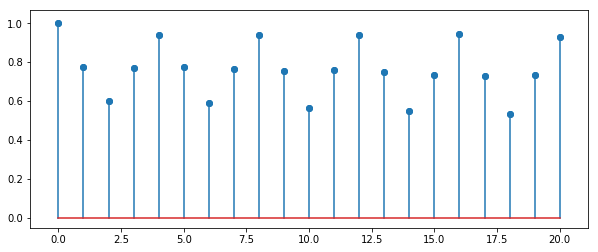

In [9]:
# Write your code here
def acf(values, lags):
    acf = []
    acf.append(stats.pearsonr(values, values)[0])
    for lag in range(1, lags + 1):
        acf.append(stats.pearsonr(values[:-lag], values[lag:])[0])
    return acf

x = range(21)
y = acf(y_combined, 20)

plt.figure(figsize=(10, 4))
plt.stem(x, y)
plt.scatter(x, y)

What does the graph above tell you about the trend in the data?  How would you explain it to a colleague who is not familiar with the ACF plots nor how they can be used to assess whether there is a trend in the data?

# Write your answer here
SInce the correlation starts out large and positive and decreases with increasing lag, there is a trend. This is because past values can be used to predict future values when there is a trend, but as you increase the lag, noise and non-linearity make it harder to predict the values. Since the correlation increases and decreases with a clear pattern and is large every 4 lags, there is a seasonality of 4. This is because when there is a seasonality, large values of the previous season coincide with large values of the next season, making it easy to predict the next season given the previous season.

* While the example above focused  on a single sine wave with an amplitude of  1.2 and a frequency of 4 months. Real time series often have other embedded signals. for instance, in addition to a quarterly seasonality, the data may contain a less robust monthly sign 


* A weaker monthly signal means that:
1. The signal has a weaker (smaller amplitude). Let's assume the amplitude here is 0.3
2. The signal's frequency is one month

* Plot the second harmonic based on the information above. Include the first harmonic signal as a reference. Your plot should look like the following.

<img src="images/harmonic_example.png" alt="drawing" style="width:800px;"/>

* Do not forget to label the lines

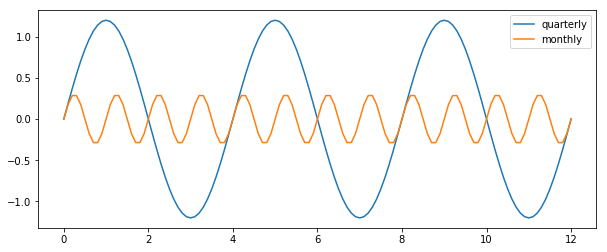

In [10]:
#### Write your code here
x = np.arange(0, 200, 0.1)
y_first_harmonic = np.sin(np.pi / 2 * x) * 1.2
y_second_harmonic = np.sin(2 * np.pi * x) * 0.3

plt.figure(figsize=(10, 4))
plt.plot(x[:121], y_first_harmonic[:121], label='quarterly')
plt.plot(x[:121], y_second_harmonic[:121], label='monthly')
plt.legend()

Plot the full signal which include the the first and the second harmonics. Your plot should look like the following.

<img src="images/combined_sines.png" alt="drawing" style="width:900px;"/>

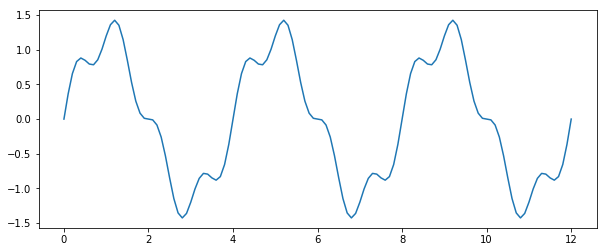

In [11]:
# Write your code here
y_harmonics = y_first_harmonic + y_second_harmonic

plt.figure(figsize=(10, 4))
plt.plot(x[:121], y_harmonics[:121])

2. Generate the new time series which includes the trend, both signal, and the stochastic noise. Your final results should look like the following

<img src="images/signal_with_monthly.png" alt="drawing" style="width:800px;"/>




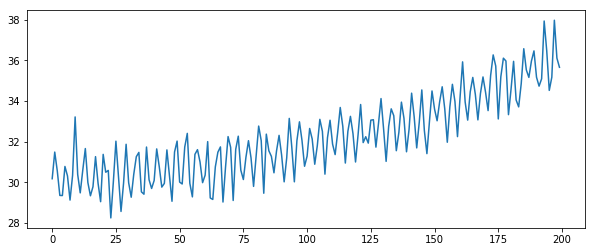

In [12]:
# Write you code here
y_noise = np.random.normal(0, 0.5, 200)
y_combined = y_trend + y_harmonics[::10] + y_noise

plt.figure(figsize=(10, 4))
plt.plot(x_combined, y_combined)

### Question 2: time Series Modeling of Passenger Count for International Flight from LAX

Initially, the approach used here will be very similar to that used above. We will show that not all that which looks seasonal can be easily fitted using a line but can be, instead, forecasted using triple exponential smoothing. 


We will be using a dataset reporting the Los Angeles International Airport Passenger Traffic By Terminal. The data is in the file `data/LAX_final.csv`  and is formatted as a CSV (comma separated values). The dataset contains multiple fields, but we are only interested in modeling the international departures for LAX between 2009 and 2017. 

Load the data as a pandas DataFrame and used `head()` to make sure the data was read correctly. 

Name you `DataFrame`  as `lax`


In [13]:
# Write you code here
lax = pd.read_csv('data/LAX_final.csv')
lax.head()

,ReportPeriod,Terminal,Arrival_Departure,Domestic_International,Passenger_Count
0,01/01/2006 12:00:00 AM,Imperial Terminal,Arrival,Domestic,490
1,01/01/2006 12:00:00 AM,Imperial Terminal,Departure,Domestic,498
2,01/01/2006 12:00:00 AM,Misc. Terminal,Arrival,Domestic,753
3,01/01/2006 12:00:00 AM,Misc. Terminal,Departure,Domestic,688
4,01/01/2006 12:00:00 AM,Terminal 1,Arrival,Domestic,401535


We are only interested in values associated with international departures. Write an expression to retain only lines where "Arrival_Departure" is equal to "Departure" and "Domestic_International" is equal to "International".
 
Also, we are also only interested in the columns `ReportPeriod` (i.e., the period covered) and the `Passenger_Count`, the number of passengers reported during that period. 
Create a new  `DataFrame`  (`Lax_int_dep`) which contains only these two columns and only international departures. 






In [14]:
# Write you code here
Lax_int_dep = lax[(lax['Arrival_Departure'] == 'Departure') & (lax['Domestic_International'] == 'International')][['ReportPeriod', 'Passenger_Count']]

Compute the total number of passengers (`Passenger_Count`) per month. 
Call your new DataFrame `lax_totals`. Use the shape attribute to make sure that your resulting DataFrame matches the expected results --  recall that the data has reported values for January 2006 through January 2019.


In [15]:
# Write you code here
lax_totals = Lax_int_dep.groupby('ReportPeriod').sum()
months_expected = 12 * (2019 - 2006) + 1
lax_totals.shape[0] == months_expected

True

Recall that changing the index of time series dataset simplifies the analysis.  Change the type of your index DataTime Index. Set  the frequency of your observations to month start (`MS`).

In [16]:
# Write your code here
lax_totals.index = pd.to_datetime(lax_totals.index)
lax_totals.sort_index(inplace=True)
lax_totals = lax_totals.asfreq('MS')

The reporting reported includes the financial crisis of 2007-2009 https://en.wikipedia.org/wiki/Financial_crisis_of_2007%E2%80%932008. 

According to news reports, travel in 2009 was ["ravaged"](https://skift.com/2018/09/14/10-years-later-how-the-travel-industry-came-back-from-the-financial-crisis/)

Plot the data and see for yourself that the number right before 2009 are significantly lower than during the 2006-2008 perio. Your plot should look like the following.


<img src="images/lax_complete.png" alt="drawing" style="width:800px;"/>


Hint: If your data does not look like the following, then check that your DataFrame `index`  **makes sense**


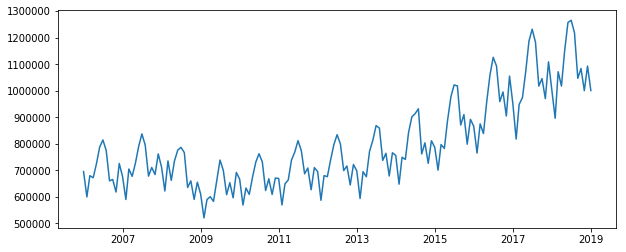

In [17]:
# Write your code here
plt.figure(figsize=(10, 4))
plt.plot(lax_totals.index, lax_totals)

It would be reasonable to remove data prior to the 2009 financial crisis so that the model is not affected by this `rare` anomaly. Build a new `DataFrame` and call it `lax_totals_post_08`. Use shape to make sure the data contains the expected number of entries.
It should contain 12 entries for each of the years 2009 through 2018. Plus January 2019.

In [18]:
# Write your code here
lax_totals_post_08 = lax_totals[36:]
months_expected = 12 * (2019 - 2009) + 1
lax_totals_post_08.shape[0] == months_expected

True

Plot the data to make sure the data does not contain the dip associated with 2008.

Your graph should look like the following


<img src="images/lax_totals_post_08.png" alt="drawing" style="width:800px;"/>


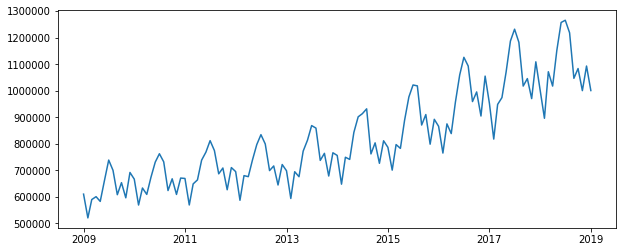

In [19]:
# Write your code here
plt.figure(figsize=(10, 4))
plt.plot(lax_totals_post_08.index, lax_totals_post_08)

* The dataset exhibits clear trends and seasonality. We will tackle the modeling of the trend prior to "attempting" to model the seasonality.

* Find the best fitting trend line and use it to detrend the data. You can achieve this by using the same strategy as that covered in class. Specifically,  you need to approximate the data using a power function $y = a x^b$, where are $a$ and $b$ are the constants you need to find.
  * use the `curve_fit` from the scipy.optimize module  to find the curve that best matches `lax_totals_post_08`
  

* Plot your best fitting trend as well as your data. Your graph should look like the following.


<img src="images/trend.png" alt="drawing" style="width:900px;"/>


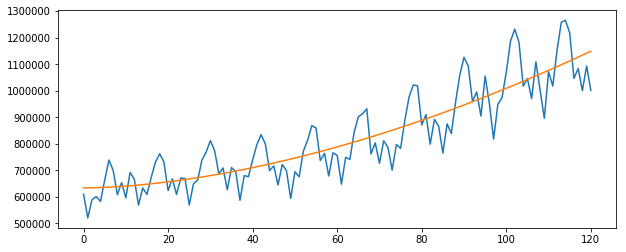

In [20]:
# Write your code here
def power_function(x, a, b, c):
    return a * x ** b + c

x = np.arange(len(lax_totals_post_08))
popt, pcov = curve_fit(power_function, x, lax_totals_post_08['Passenger_Count'])

plt.figure(figsize=(10, 4))
plt.plot(x, lax_totals_post_08)
plt.plot(x, power_function(x, *popt))

* In what follows we are going to "try" to identify the seasonality in the data. The approach we will use is similar to that followed in class and above.

* Detrend your data; i.e., Remove the trend so that seasonality is easier to observe. call the detrended data lax_totals_post_08_detrd

* Plot your data to make sure the data is detrended. Your graph should look like the following
  * Plot a horizontal line at y=0 to highlight the seasonality
    
    
<img src="images/detrended.png" alt="drawing" style="width:800px;"/>



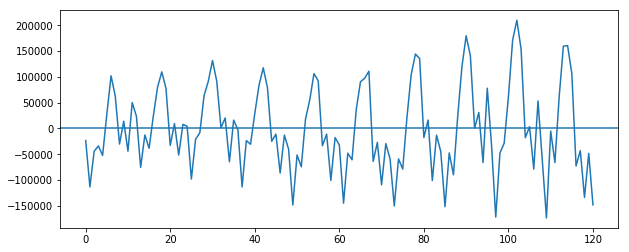

In [21]:
# Write you code here
lax_totals_post_08_detrd = lax_totals_post_08['Passenger_Count'] - power_function(x, *popt)

plt.figure(figsize=(10, 4))
plt.plot(x, lax_totals_post_08_detrd)
plt.axhline(0)

* Use the ACF plot to find the highest correation non-zero lag

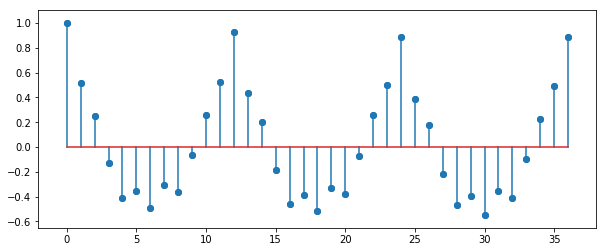

In [22]:
# Write you code here
x = range(37)
y = acf(lax_totals_post_08_detrd, 36)

plt.figure(figsize=(10, 4))
plt.stem(x, y)
plt.scatter(x, y)

* Rather manually and iteratively finding all the harmonics in the signal, we will use the code below which fit a signal using a user defined `n_harm` number of harmonincs. For instance, the fitted signal using 1, 3, 5, 10 harmonics is giving below.

<img src="images/harmonics.png" alt="drawing" style="width:1000px;"/>

* I computed the graph above using code I obtained from the following gist:
https://gist.github.com/tartakynov/83f3cd8f44208a1856ce

In [23]:
import numpy as np
import pylab as pl
from numpy import fft
    
def fourierExtrapolation(x, n_predict=0, n_harm=1):
    n = x.size
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = fft.fft(x_notrend)  # detrended x in frequency domain
    f = fft.fftfreq(n)              # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

Note from the above that even with 10 harmonics, we are still not able to effectively capture the seasonality in our data. Further increasing the number of harmonics improves the fits but leads to a very poor forecasting power -- this is referred to as overfitting. We will cover overfitting in more details in future sessions. 

We suspect that perhaps the data is not stationary. To quickly test this, we can compute the mean and variance of the data for the first half and the second half of the data. 


In [24]:
print(lax_totals_post_08_detrd[0:62].mean(), lax_totals_post_08_detrd[0:62].var())
print(lax_totals_post_08_detrd[62:].mean(), lax_totals_post_08_detrd[62:].var())

-1930.3909073400127 4405425270.413101
2028.5464000970942 9699492796.889872



The mean and the variance are largely different across the first half and the second half. This means that the variability across both subsets don't have the same parameters, indicating that the data is non-stationary; i.e. not exhibiting the same behavior all across. Recall that we said that non-stationary data is difficult, if not impossible model and forecast using line-fitting. This makes sense since no one model can accommodate the different distributions contained across different time subsets.

Instead of modeling the data using a line, you will use triple exponential smoothing (.i.e., exponential smoothing with trend and seasonality added). 

Will use the `ExponentialSmoothing` from `statsmodels.tsa.holtwinters` to model years 2009 to 2017. We will then try to predict the values of January 2018 to January 2019 and compare our prediction with the real data.

Build two subsets of your data as follows:
    
- The first subset will only contain entries from January 2009 to December 2017 in the original dataset (`lax_totals_post_08`). Call that subset which `training_data`
- The second subset will contain entries from January 2018 to January 2019 from the original dataset (`lax_totals_post_08`). Call that subset which `testing_data.`
- use shape to make sure you have the right number of values in each of `training_data` and `testing_data`

In [25]:
# Write your code here
training_data = lax_totals_post_08[:'2017']
testing_data = lax_totals_post_08['2018':]
expected_training_months = 12 * (2018 - 2009)
expected_testing_months = 12 * (2019 - 2018) + 1
training_data.shape[0] == expected_training_months and testing_data.shape[0] == expected_testing_months

True

Use `ExponentialSmoothing` from  `statsmodels.tsa.holtwinters` module to fit the training_data. The steps are similar to those we used while fitting a scikit model. 

1 Build an instance of `ExponentialSmoothing` using the appropriate trend and seasonality
  * Consult the documentation for more info (or explore the different parameters to better understand what they do)

2 Call the  fit() on  the  `ExponentialSmoothing` instance you constructed

The complete expression for accomplishing steps 1 and 2 is:

```python
ExponentialSmoothing(training_data, trend="SOMETHING GOES HERE", seasonal="SOMETHING GOES HERE", seasonal_periods=12).fit()
```
There are two possible sources of error here with the statement above:

1. training_data does not have a proper index (monthly start)
2. The model does not converge using the combination of  `trend` and `seasonal` used; some combinations cause the model to fail to find appropriate values for $\alpha$, $\beta$ and $\gamma$ the params of the triple exponential smoothing model.  (+5 points if you can figure this out and clearly explain why your solution works.)



In [26]:
# write your code here
fit = ExponentialSmoothing(training_data, trend='add', seasonal='add', seasonal_periods=12).fit()


* Use the fitted model to predict values that match the 2018 and 2019. 
  * predict takes two parameters; `start` and `end`, those should be the first date and the last date in your testing_data.


* In the same figure, plot:
    
  * Your training data for the period spanning between Jan 2009 and Jan 2017
  * Your prediction for the period spanning between Jan 2018 and Jan 2019
  * The true observed values  spanning between Jan 2018 and Jan 2019 


Depending on your choices of trend and seasonality, your plot should show something like the following:

<img src="images/prediction.png" alt="drawing" style="width:1000px;"/>



HINT2: I've specifically omitted y-axis values form my plot as they are a tell-tale for what you need to do before fitting your data.

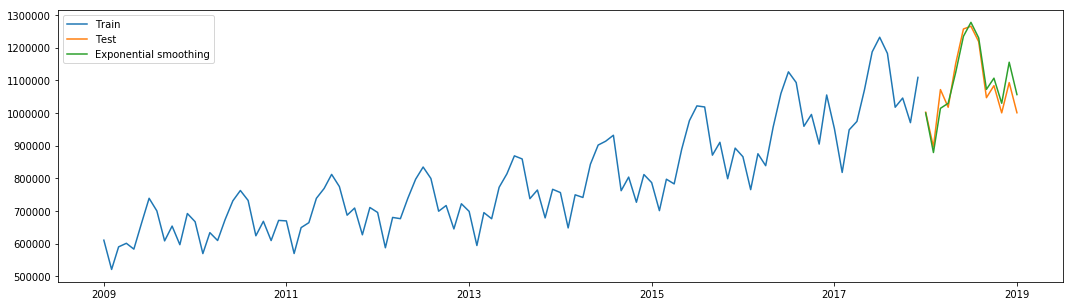

In [27]:
# Write your code here
predict = fit.predict(testing_data.head(1).index[0], testing_data.tail(1).index[0])

plt.figure(figsize=(18, 5))
plt.plot(training_data.index, training_data, label='Train')
plt.plot(testing_data.index, testing_data, label='Test')
plt.plot(predict.index, predict, label='Exponential smoothing')
plt.legend()

### Clustering

The file `data/mvmt.csv` contains data from wearable devices (fitbit-like) on the activity (movement) as measured from 62 individuals recorded during a 5 minutes time interval. We are told that the individuals were either sleeping, running or walking.

In this exercise, you will use `k-means` clustering algorithm to cluster the time series data and report which, in your opinion were the individuals in each category (i.e., sleeping, running or walking). 

An important particularity of this dataset is that firs the first cohort of individuals, the activity was measured each second while for the second cohort, the activity was measured every 2 seconds.


Read the data into a variable called `activities` and display the 10 first lines and the last 10 lines. Observe that for the individuals who were sampled every two seconds, half of the data contains missing values (NaNs).


In [28]:
# Write your code here
activities = pd.read_csv('data/activity.csv')
activities.head(10)
activities.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,52,53,54,55,56,57,58,59,60,61
290,12.116825,10.885400,14.168997,15.100285,13.301519,11.372673,13.412007,14.858282,10.568657,14.349623,...,19.691936,16.171265,18.500946,18.394696,NaN,NaN,NaN,NaN,NaN,NaN
291,12.467893,10.906224,13.931477,14.492089,13.352267,11.375528,13.607170,14.994554,9.531037,14.266581,...,19.684388,17.081737,18.496662,18.655685,NaN,NaN,NaN,NaN,NaN,NaN
292,12.418100,9.718767,13.993442,15.214408,13.445805,11.184740,13.790861,14.846096,9.487124,14.273386,...,19.761579,15.885948,18.389838,18.712782,NaN,NaN,NaN,NaN,NaN,NaN
293,12.612415,10.486277,14.120197,15.088221,13.662963,11.103332,13.541718,14.908558,10.530685,14.295661,...,19.643568,15.909133,18.615129,18.498901,NaN,NaN,NaN,NaN,NaN,NaN
294,12.741490,9.214888,14.202957,14.586205,13.682559,11.240596,13.552705,14.731222,10.180831,14.259842,...,19.347595,15.859156,18.643241,18.445079,NaN,NaN,NaN,NaN,NaN,NaN
295,13.015216,9.876241,14.165899,14.463930,13.744169,11.261775,13.410789,14.838185,9.999843,14.339006,...,19.403287,16.185251,18.711837,18.244215,NaN,NaN,NaN,NaN,NaN,NaN
296,12.822231,10.310336,14.139935,15.218280,13.665840,11.378658,13.159088,14.681346,10.224737,14.477577,...,19.845535,15.678376,18.942684,18.583586,NaN,NaN,NaN,NaN,NaN,NaN
297,12.959442,9.332328,14.148697,13.818534,13.719665,11.773946,13.115684,13.956486,9.492620,14.624505,...,19.768138,15.695432,18.918036,18.981066,NaN,NaN,NaN,NaN,NaN,NaN
298,13.171127,10.305293,14.119297,15.309577,13.651027,11.461097,13.053988,14.984471,10.208223,14.427344,...,20.081987,15.204785,19.330079,19.111129,NaN,NaN,NaN,NaN,NaN,NaN
299,12.819379,10.540390,14.312073,15.010397,13.775341,11.784540,13.539331,14.876798,9.508848,14.370513,...,19.931529,16.469298,19.240516,19.282820,NaN,NaN,NaN,NaN,NaN,NaN


We need to resample the data and get fit of the missing values. Imagine we have the following dataset ( `a=[1,2,3,4,5,6,], b=[1,3,5, nan, nan, nan]`) , where `a` was sampled every second and b was sampled every two second. A simple approach to align `a and `b` is to drop values at every even position in a and remove missing values form `b`. Dropping values at even positions in a will yield `a = [1,3,5,]`. Removing missing values will result in `b` becoming `[1,3,5]`. The values are now aligned and can be compared.


Implement the strategy above to align all you data.

In [195]:
# Write you code here
a = activities[activities.columns[activities.notna().all()]].loc[::2]
b = activities[activities.columns[activities.isna().any()]].dropna()
b.index = a.index
activities_cleaned = pd.concat([a, b], 1)
activities_cleaned = activities_cleaned.T
activities_cleaned.index = activities_cleaned.index.astype(int)
activities_cleaned.sort_index(inplace=True)

* Use the `k-means` algorithm as implemented in the `scikit-learn`  to cluster activities data into the three groups they belong to (sleeping, running or walking). 


In [210]:
# Write your code here
kmeans = KMeans(n_clusters=3).fit_predict(activities_cleaned)

Plot the time series using three different colors, each representing one of the three clusters. Your plot should look like the following.

 * For simplicity, this sample plot contains only a small subset of the data. You graph should contain all the data. 
 
<img src="images/activities.png" alt="drawing" style="width:800px;"/>


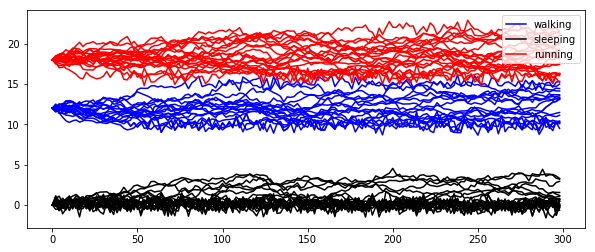

In [229]:
# Write your code here
x = activities_cleaned.columns

plt.figure(figsize=(10, 4))
plt.plot(x, activities_cleaned.iloc[activities_cleaned[kmeans == 0].index[0]], c='blue', label='walking')
plt.plot(x, activities_cleaned.iloc[activities_cleaned[kmeans == 1].index[0]], c='black', label='sleeping')
plt.plot(x, activities_cleaned.iloc[activities_cleaned[kmeans == 2].index[0]], c='red', label='running')
plt.legend()
for i in activities_cleaned[kmeans == 0].index:
    plt.plot(x, activities_cleaned.iloc[i], c='blue')
for i in activities_cleaned[kmeans == 1].index:
    plt.plot(x, activities_cleaned.iloc[i], c='black')
for i in activities_cleaned[kmeans == 2].index:
    plt.plot(x, activities_cleaned.iloc[i], c='red')